In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Load in ROI labels and visualize
roi_labels = np.load('parcel_roi_labels.npy')
roi_names = ['L_PostTemp', 'L_AntTemp', 'L_AngG', 'L_IFG', 'L_MFG',
             'L_IFGorb', 'L_vmPFC', 'L_dmPFC', 'L_PMC', 'L_HG', 'L_V1',
             'R_PostTemp', 'R_AntTemp', 'R_AngG', 'R_IFG', 'R_MFG',
             'R_IFGorb', 'R_vmPFC', 'R_dmPFC', 'R_PMC', 'R_HG', 'R_V1']

# Set V1 to zero and ignore
v1_ids = [i for i, r in enumerate(roi_names) if 'V1' in r]
for v1_id in v1_ids:
    roi_labels[roi_labels == v1_id + 1.] = 0.

roi_ids = np.where(roi_labels != 0)[0]

In [3]:
# Load in embeddings (layers 1-12) and transformations
parcel_emb = np.load('data_plots_2022-04-23/layer_performances.npy')[1:]
parcel_z = np.load('data_plots_2022-04-23/z_performances.npy')

In [4]:
# Select parcels in language ROIs
parcel_emb = parcel_emb[..., roi_ids]
parcel_z = parcel_z[..., roi_ids]

In [5]:
# Truncate extreme percent noise ceiling values
parcel_emb[parcel_emb > 100] = 100
parcel_emb[parcel_emb < -100] = -100

parcel_z[parcel_z > 100] = 100
parcel_z[parcel_z < -100] = -100

In [6]:
# Average performances acrosss subjects
parcel_emb_mean = np.mean(parcel_emb, axis=1)
parcel_z_mean = np.mean(parcel_z, axis=1)

In [7]:
# Get layer with max performance
parcel_emb_max = np.argmax(parcel_emb_mean, axis=0) + 1
parcel_z_max = np.argmax(parcel_z_mean, axis=0) + 1

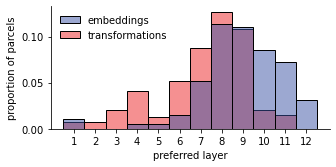

In [8]:
# Plot layer preference for embeddings and transformations
hist_df = pd.DataFrame({'embeddings': parcel_emb_max,
                        'transformations': parcel_z_max})
colors = ['#3a53a4ff', '#ed2224ff']

fig, ax = plt.subplots(figsize=(5, 2.25))
sns.histplot(hist_df, stat='proportion', discrete=True, ax=ax,
             palette=sns.color_palette(colors), legend=True)
ax.set_ylabel('proportion of parcels')
ax.set_xlabel('preferred layer')
ax.set_xticks(np.arange(1, 13))
ax.set_yticks(np.arange(0, .15, .05))
legend = ax.get_legend()
handles = legend.legendHandles
legend = ax.legend(handles, ['embeddings', 'transformations'], frameon=False)
sns.despine()
plt.savefig('layer_preference_histogram.svg', bbox_inches='tight', dpi=300)

In [9]:
# Compute observed different between preferred layers
diff_obs = np.mean(parcel_emb_max - parcel_z_max)

# Stack embeddings and transformations
parcel_stack = np.stack([parcel_emb, parcel_z], axis=-1)

# Shuffle embeddings and transformations in loop
rng = np.random.default_rng()
n_perms = 1000

null_dist = []
for i in np.arange(n_perms):
    parcel_perm = rng.permuted(parcel_stack, axis=-1)
    parcel_emb_perm, parcel_z_perm = parcel_perm[..., 0], parcel_perm[..., 1]

    # Average shuffled performances acrosss subjects
    parcel_emb_perm = np.mean(parcel_emb_perm, axis=1)
    parcel_z_perm = np.mean(parcel_z_perm, axis=1)

    # Get layer with max performance
    parcel_emb_perm = np.argmax(parcel_emb_perm, axis=0) + 1
    parcel_z_perm = np.argmax(parcel_z_perm, axis=0) + 1
    
    # Get difference for permuted performances
    diff_perm = np.mean(parcel_emb_perm - parcel_z_perm)
    null_dist.append(diff_perm)

In [10]:
# Compute p-value from null distribution
def p_from_null(observed, distribution):
    n_samples = len(distribution)
    numerator = np.sum(np.abs(distribution) >= np.abs(observed))
    p = (numerator + 1) / (n_samples + 1)
    return p

p = p_from_null(diff_obs, null_dist)
print(f"embeddings: mean preferred layer = {np.mean(parcel_emb_max):.3f}")
print(f"transformations: mean preferred layer = {np.mean(parcel_z_max):.3f}")
print(f"p = {p:.3f}")

embeddings: mean preferred layer = 8.861
transformations: mean preferred layer = 7.196
p = 0.001


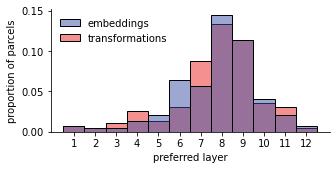

In [11]:
# Plot plot an example shuffled histogram
hist_df = pd.DataFrame({'embeddings': parcel_emb_perm,
                        'transformations': parcel_z_perm})
colors = ['#3a53a4ff', '#ed2224ff']

fig, ax = plt.subplots(figsize=(5, 2.25))
sns.histplot(hist_df, stat='proportion', discrete=True, ax=ax,
             palette=sns.color_palette(colors), legend=True)
ax.set_ylabel('proportion of parcels')
ax.set_xlabel('preferred layer')
ax.set_xticks(np.arange(1, 13))
legend = ax.get_legend()
handles = legend.legendHandles
legend = ax.legend(handles, ['embeddings', 'transformations'], frameon=False)
sns.despine()

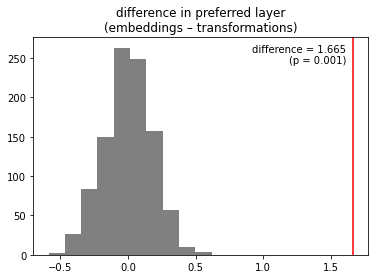

In [12]:
# Plot null distribution and observed value
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(null_dist, color='.5')
ax.axvline(diff_obs, c='red')
ax.set_title(('difference in preferred layer\n'
              '(embeddings – transformations)'))
ax.annotate(f"difference = {diff_obs:.3f}\n(p = {p:.3f})",
            (diff_obs - .05, .97),
            xycoords=('data', 'axes fraction'),
            ha='right', va='top');

In [13]:
# Compute magnitude of layerwise differences
def layer_diff(parcel_means):
    diff = np.linalg.norm(np.diff(parcel_means, axis=0), 2, axis=0)
    return diff

diff_obs = np.mean(layer_diff(parcel_emb_mean) - 
                   layer_diff(parcel_z_mean))

# Stack embeddings and transformations
parcel_stack = np.stack([parcel_emb, parcel_z], axis=-1)

# Shuffle embeddings and transformations in loop
rng = np.random.default_rng()
n_perms = 1000

null_dist = []
for i in np.arange(n_perms):
    parcel_perm = rng.permuted(parcel_stack, axis=-1)
    parcel_emb_perm, parcel_z_perm = parcel_perm[..., 0], parcel_perm[..., 1]

    # Average shuffled performances acrosss subjects
    parcel_emb_perm = np.mean(parcel_emb_perm, axis=1)
    parcel_z_perm = np.mean(parcel_z_perm, axis=1)
    
    # Get difference in layerwise differences for permuted performances
    diff_perm = np.mean(layer_diff(parcel_emb_perm) - 
                        layer_diff(parcel_z_perm))
    null_dist.append(diff_perm)

In [14]:
# Compute p-value from null distribution
def p_from_null(observed, distribution):
    n_samples = len(distribution)
    numerator = np.sum(np.abs(distribution) >= np.abs(observed))
    p = (numerator + 1) / (n_samples + 1)
    return p

p = p_from_null(diff_obs, null_dist)
print("embeddings: mean layerwise difference = "
      f"{np.mean(layer_diff(parcel_emb_mean)):.3f}")
print("transformations: mean layerwise difference = "
      f"{np.mean(layer_diff(parcel_z_mean)):.3f}")
print(f"p = {p:.3f}")

embeddings: mean layerwise difference = 7.575
transformations: mean layerwise difference = 14.321
p = 0.001


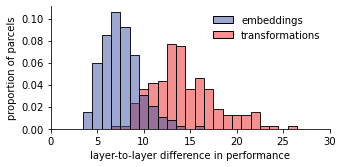

In [15]:
# Plot histogram of layerwise difference in performance magnitude
hist_df = pd.DataFrame({'embeddings': layer_diff(parcel_emb_mean),
                        'transformations': layer_diff(parcel_z_mean)})
pd.melt(hist_df, var_name='feature', value_name='layer specificity')
colors = ['#3a53a4ff', '#ed2224ff']

fig, ax = plt.subplots(figsize=(5, 2.25))
sns.histplot(hist_df, stat='proportion', bins=np.arange(0, 30) - .5, binrange=(0, 30),
             ax=ax, palette=sns.color_palette(colors))
ax.set_xlabel('layer-to-layer difference in performance')
ax.set_ylabel('proportion of parcels')
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 31, 5))
legend = ax.get_legend()
handles = legend.legendHandles
legend = ax.legend(handles, ['embeddings', 'transformations'], frameon=False)
sns.despine()
plt.savefig('layer_specificity_histogram.svg', bbox_inches='tight', dpi=300)

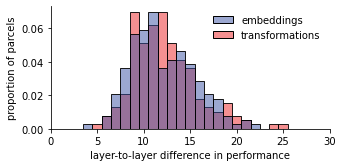

In [16]:
# Plot histogram of shuffled layerwise difference in performance magnitude
hist_df = pd.DataFrame({'embeddings': layer_diff(parcel_emb_perm),
                        'transformations': layer_diff(parcel_z_perm)})
pd.melt(hist_df, var_name='feature', value_name='layer specificity')
colors = ['#3a53a4ff', '#ed2224ff']

fig, ax = plt.subplots(figsize=(5, 2.25))
sns.histplot(hist_df, stat='proportion', bins=np.arange(0, 30) - .5, binrange=(0, 30),
             ax=ax, palette=sns.color_palette(colors))
ax.set_xlabel('layer-to-layer difference in performance')
ax.set_ylabel('proportion of parcels')
ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, 31, 5))
legend = ax.get_legend()
handles = legend.legendHandles
legend = ax.legend(handles, ['embeddings', 'transformations'], frameon=False)
sns.despine()

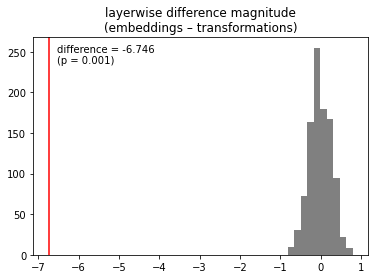

In [17]:
# Plot null distribution and observed value
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(null_dist, color='.5')
ax.axvline(diff_obs, c='red')
ax.set_title(('layerwise difference magnitude\n'
              '(embeddings – transformations)'))
ax.annotate(f"difference = {diff_obs:.3f}\n(p = {p:.3f})",
            (diff_obs + .2, .97),
            xycoords=('data', 'axes fraction'),
            ha='left', va='top');